# <center>Линейная регрессия, Lasso и RF-регрессия в задаче гендерной классификации пользователей Вконтакте</center>

**Татьяна Шаврина, Ангелина Кудрявцева**

In [176]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.regression import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import re

**Будем работать с прежним набором данных по профилям ВК**
**Загружаем данные.**

In [112]:
data = pd.read_csv(r'G:\GICRL_Knowledge_Base\достоверность_профилей\для_выборки\VK\final_vkprofiles.csv', sep=';',  encoding='utf-8')
data.head()

,city_title,first_name,last_name,screen_name,can_see_all_posts,has_mobile,country_id,country_title,online,sex,...,artist,lyrics_id,date,duration,status_audio_id,owner_id,genre_id,album_id,no_search,deactivated
0,Кингисепп,Maria,Maria,id95596964,0,1,1,Россия,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ахтырка,Женя,Кузнецова,id228580388,1,1,2,Украина,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Кореновск,Валерий,Тарасов,id342844772,1,1,1,Россия,1.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Винница,Виктория,Левченко,id299763940,1,1,2,Украина,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Braga,Vrat,Zart,id348030308,1,1,161,Португалия,1.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38751 entries, 0 to 38750
Data columns (total 68 columns):
city_title                         26750 non-null object
first_name                         38751 non-null object
last_name                          38751 non-null object
screen_name                        38658 non-null object
can_see_all_posts                  38535 non-null object
has_mobile                         38684 non-null object
country_id                         28645 non-null object
country_title                      28726 non-null object
online                             38629 non-null float64
sex                                38472 non-null object
photo_medium                       38468 non-null object
bdate                              22948 non-null object
can_post                           38453 non-null object
home_phone                         2063 non-null object
photo                              38451 non-null object
can_write_private_message          3

**Почистим данные**

In [114]:
data = data[(data['sex']== '0' )|(data['sex']=='1') |(data['sex']=='2')|(data['sex']==None)]

In [115]:
data['sex_num'] = data['sex'].astype(float)

In [116]:
data = data[(data['relation']== '0' )|(data['relation']=='1') |(data['relation']=='2')|(data['relation']=='3')|(data['relation']=='4')|(data['relation']=='5')|(data['relation']=='6')|(data['relation']=='7')|(data['relation']==None)]

In [117]:
def birth_year(age):
    if re.search(r'\d{4}', str(age)):
        result = re.search(r'\d{4}', str(age))
        #print(result.group(0))
        return int(result.group(0))
    else:
        return None

In [118]:
birth_years = [birth_year(age) for age in data.bdate]

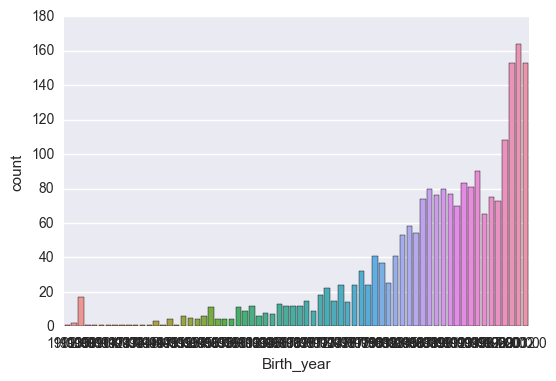

In [119]:
data['Birth_year'] = birth_years
#data['Birth_year'].hist(normed=True)
#plt.title('Birth year statistics')
#plt.show()
sns.countplot(x = data['Birth_year'])

In [113]:
# для этого создадим новый признак 'Info_count'
for i in range(data.shape[0]):
    #print (i)
    data.at[i,'Info_count'] = len(data.loc[i, ['city_title','first_name','last_name','screen_name','can_see_all_posts','has_mobile','country_id','country_title','online','sex','photo_medium', 'bdate','can_post','home_phone','photo','can_write_private_message', 'activity','nickname','id_1','photo_big','platform','time', 'university_name','faculty','relation','country', 'universities_university_id','name','city','education_form','graduation', 'chair_name','faculty_name','universities_university_faculty','chair', 'education_status','online_mobile','university','online_app','videos','notes','audios','photos','followers', 'albums','gifts','groups','user_videos','relation_partner_first_name', 'relation_partner_last_name','relation_partner_id','hidden', 'status_audio_title','url','artist','lyrics_id','date','duration','status_audio_id','owner_id','genre_id','album_id','no_search','deactivated']].dropna())

In [120]:
data = data.fillna(data.median(axis=0), axis=0)

**Отделим целевой признак (пол), разделим обучающую выборку в отношении 7:3 (30% - под оставленную выборку, пусть random_state=7) и отмасштабируем данные с помощью StandardScaler.**

In [123]:
data1 = data
data1 = data1.drop(['city_title'], axis=1)
data1 = data1.drop(['first_name'], axis=1)
data1 = data1.drop(['last_name'], axis=1)
data1 = data1.drop(['screen_name'], axis=1)
data1 = data1.drop(['country_title'], axis=1)
data1 = data1.drop(['photo_medium'], axis=1)
data1 = data1.drop(['photo_big'], axis=1)
data1 = data1.drop(['bdate'], axis=1)
data1 = data1.drop(['photo'], axis=1)
data1 = data1.drop(['activity'], axis=1)
data1 = data1.drop(['nickname'], axis=1) 
data1 = data1.drop(['education_form'], axis=1)
data1 = data1.drop(['chair_name'], axis=1)
data1 = data1.drop(['faculty_name'], axis=1)
data1 = data1.drop(['universities_university_faculty'], axis=1)
data1 = data1.drop(['universities_university_id'], axis=1)
data1 = data1.drop(['name'], axis=1)
data1 = data1.drop(['chair'], axis=1)
data1 = data1.drop(['education_form_1'], axis=1)
data1 = data1.drop(['education_status'], axis=1)
data1 = data1.drop(['faculty_name_1'], axis=1)
data1 = data1.drop(['education_status_1'], axis=1)
data1 = data1.drop(['relation_partner_first_name'], axis=1)
data1 = data1.drop(['relation_partner_last_name'], axis=1)
data1 = data1.drop(['status_audio_title'], axis=1)
data1 = data1.drop(['url'], axis=1)
data1 = data1.drop(['artist'], axis=1)
data1 = data1.drop(['deactivated'], axis=1)
data1 = data1.drop(['country'], axis=1)
data1 = data1.drop(['faculty'], axis=1)
data1 = data1.drop(['university_name'], axis=1)
data1 = data1.drop(['date'], axis=1) 
data1 = data1.drop(['home_phone'], axis=1)

data1 = data1.drop(['relation_partner_id'], axis=1)
data1 = data1.drop(['id_1'], axis=1)
data1 = data1.drop(['lyrics_id'], axis=1)
data1 = data1.drop(['status_audio_id'], axis=1)
data1 = data1.drop(['owner_id'], axis=1)
data1 = data1.drop(['genre_id'], axis=1)
data1 = data1.drop(['album_id'], axis=1)
data1 = data1.drop(['hidden'], axis=1)


In [124]:
print(data1.columns.values)

['can_see_all_posts' 'has_mobile' 'country_id' 'online' 'sex' 'can_post'
 'can_write_private_message' 'platform' 'time' 'relation' 'city'
 'graduation' 'online_mobile' 'university' 'graduation_1' 'online_app'
 'videos' 'notes' 'audios' 'photos' 'followers' 'albums' 'gifts' 'groups'
 'user_videos' 'duration' 'no_search' 'Info_count' 'sex_num' 'Birth_year']


In [107]:
data1 = data1.fillna(data.median(axis=0), axis=0)


In [125]:
data1.to_csv(r'G:\GICRL_Knowledge_Base\достоверность_профилей\для_выборки\VK\final_vkprofiles_data_regr2.csv', sep=';')

In [226]:
X = pd.read_csv(r'G:\GICRL_Knowledge_Base\достоверность_профилей\для_выборки\VK\final_vkprofiles_data_regr3.csv', sep=';',  encoding='utf-8')
y = data['sex_num']

X = X.drop(['sex_num'], axis=1)
X = X.drop(['sex'], axis=1)

In [228]:
X_train, X_30, y_train, y_30 = train_test_split(X, y, test_size=0.3, random_state=7)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_30_scaled = scaler.transform(X_30)

## Линейная регрессия

**Обучим простую линейную регрессию.**

In [229]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Оценим среднеквадратичную ошибку модели на обучающей и отложенной выборках.**

In [230]:
# на обучающей
predicted_error = linreg.predict(X_train_scaled)
mean_squared_error (y_train, predicted_error)

0.25200822743092083

In [231]:
# на отложенной
predicted_error_30 = linreg.predict(X_30_scaled)
mean_squared_error (y_30, predicted_error_30)

0.25075113870443955

**Посмотрим на коэффициенты модели и отранжируем признаки по влиянию (большие по модулю отрицательные значения коэффициентов тоже говорят о сильном влиянии). Создайте для этого новый небольшой DataFrame.**

In [232]:
linreg_coef = pd.DataFrame(linreg.coef_,index=X.columns)
linreg_coef.sort_values(0)

,0
gifts,-1.593439e-02
graduation_1,-1.437268e-02
photos,-1.358237e-02
followers,-1.006513e-02
albums,-9.432200e-03
relation,-7.782715e-03
country_id,-7.123168e-03
user_videos,-6.677245e-03
online,-4.835052e-03
can_see_all_posts,-2.289498e-03


## Lasso-регрессия

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha = 0.01$ (слабая регуляризация). Пусть опять random_state=7.**

In [233]:
alpha = 0.01
lasso_small = Lasso(alpha, random_state=7)
lasso_small.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=7,
   selection='cyclic', tol=0.0001, warm_start=False)

**Посмотрим на коэффициенты модели и отранжируйте признаки по влиянию на качество вина. Какой признак "отвалился" первым, то есть наименее важен для объяснения целевого признака в модели Lasso?**

In [234]:
lasso1_coef = pd.DataFrame(lasso_small.coef_,index=X.columns)
lasso1_coef.sort_values(0)

,0
photos,-0.004746
gifts,-0.004393
followers,-0.001220
can_see_all_posts,0.000000
no_search,0.000000
duration,0.000000
user_videos,-0.000000
groups,0.000000
albums,-0.000000
audios,0.000000


Не отвалились только признаки photos, gifts, can_post, notes,can_write_private_message, videos, online_app, has_mobile т.е. регуляризация слишком сильная.

**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации 5-кратной кросс-валидации. Используйте LassoCV и random_state=7.**

In [235]:
import numpy as np
alphas = np.linspace(0.1, 10, 200)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)
lasso_cv.alpha_

10.0

Лучшим получилось значение 10, но можно посмотреть еще и другие:

In [236]:
alphas = np.linspace(10, 15, 20)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)
lasso_cv.alpha_

15.0

Оставим 15 таким образом

In [237]:
alpha_best = 15

**Выведем коэффициенты "лучшего" Lasso в порядке убывания влияния на "пол". **

In [238]:

lasso2 = Lasso(alpha=alpha_best, random_state=7)
lasso2.fit(X_train_scaled, y_train)
lasso2_cv_coef = pd.DataFrame(lasso2.coef_,index=X.columns)
lasso2_cv_coef.sort_values(0)

,0
can_see_all_posts,0.0
no_search,0.0
duration,0.0
user_videos,-0.0
groups,0.0
gifts,-0.0
albums,-0.0
followers,-0.0
photos,-0.0
audios,0.0


Обнулилось сразу много признаков :(

**Оценим среднеквадратичную ошибку модели на обучающей и тестовой выборках.**

In [256]:
# на обучающей
predicted_error_lasso1 = lasso_small.predict(X_train_scaled)
print("MSE на обучающей, alpha=0.01: ", mean_squared_error (y_train, predicted_error_lasso1))


MSE на обучающей, alpha=0.01:  0.253613471147


In [257]:
# на обучающей
predicted_error_lasso2 = lasso2.predict(X_train_scaled)
print("MSE на обучающей, alpha=15: ",mean_squared_error (y_train, predicted_error_lasso2))

MSE на обучающей, alpha=15:  0.25725649054


In [258]:
# на тестовой 
predicted_error_lasso1 = lasso_small.predict(X_30_scaled)
print("MSE на тестовой, alpha=0.01: ", mean_squared_error (y_30, predicted_error_lasso1))

MSE на тестовой, alpha=0.01:  0.250856965063


In [259]:
# на тестовой 
predicted_error_lasso2 = lasso2.predict(X_30_scaled)
print("MSE на тестовой, alpha=15: ", mean_squared_error (y_30, predicted_error_lasso2))

MSE на тестовой, alpha=15:  0.252970301456


Видим, что у lasso2 ошибка получилась побольше

## Случайный лес

**Обучим случайный лес с параметрами "из коробки", фиксируя только random_state=7.**

In [260]:
forest = RandomForestRegressor(random_state = 7)
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

**Оценим среднеквадратичную ошибку модели на обучающей выборке, на кросс-валидации (cross_val_score с scoring='mean_squared_error' и остальными параметрами по умолчанию) и на оставленной выборке.**

In [261]:
# на обучающей
n_folds = 5
scores = cross_val_score(RandomForestRegressor(random_state = 7), X_train_scaled, y_train, 
                         scoring='mean_squared_error', cv=5)
print(scores)
scores.mean()

[-0.29244139 -0.27984814 -0.28002438 -0.28700284 -0.28329107]


-0.28452156538061052

In [262]:
# на тестовой
n_folds = 5
scores_test = cross_val_score(RandomForestRegressor(random_state = 7), X_30_scaled, y_30, 
                         scoring='mean_squared_error', cv=5)
print(scores_test)
scores_test.mean()

[-0.306551   -0.29445278 -0.30179054 -0.28411664 -0.27271053]


-0.29192429782310325

Среднеквадратичная ошибка модели на обучающей выборке каждый раз меньше, чем на тестовой, т.е. на тестовой Performance хуже

**Настроим параметры min_samples_leaf и max_depth с помощью GridSearchCV и опять проверим качество модели на кросс-валидации и на оставленной выборке.**

In [263]:
forest_params = {'max_depth': list(range(15, 20)), 
                 'min_samples_leaf': list(range(2, 8))}

locally_best_forest = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=7), 
                                 forest_params, 
                                 scoring='mean_squared_error',  
                                 n_jobs=-1, cv=5)
locally_best_forest.fit(X_train_scaled, y_train)
clf_best_param = locally_best_forest.best_params_
clf_best_param

{'max_depth': 15, 'min_samples_leaf': 7}

In [264]:
# на обучающей
n_folds = 5
scores = cross_val_score(RandomForestRegressor(min_samples_leaf = 7, max_depth = 15,random_state = 7),
                         X_train_scaled, y_train, 
                         scoring='mean_squared_error', cv=5)
print(scores) 
scores.mean()

[-0.25534629 -0.24913857 -0.2540807  -0.2577819  -0.25374217]


-0.25401792658461436

In [265]:
# на тестовой
n_folds = 5
scores_30 = cross_val_score(RandomForestRegressor(min_samples_leaf = 7, max_depth = 15,random_state = 7),
                         X_30_scaled, y_30, 
                         scoring='mean_squared_error', cv=5)
print(scores_30) 
scores_30.mean()

[-0.26451206 -0.25694759 -0.25124547 -0.25180168 -0.24321394]


-0.25354414774485867

In [266]:
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

**Оценим важность признаков с помощью случайного леса.**

In [267]:
best_forest = RandomForestRegressor(min_samples_leaf = 3, max_depth = 17, random_state = 7)
best_forest.fit(X_train_scaled, y_train)
best_forest_predictions = best_forest.predict(X_train_scaled)
rf_importance = pd.DataFrame(best_forest.feature_importances_, index=X.columns,
                        columns=['Importance']).sort(['Importance'], ascending=True)
rf_importance

,Importance
no_search,0.000000
online_mobile,0.000000
user_videos,0.000233
notes,0.002768
can_see_all_posts,0.004852
can_write_private_message,0.006515
online,0.008864
graduation_1,0.009386
duration,0.011582
can_post,0.011625


In [268]:
best_forest_30 = RandomForestRegressor(min_samples_leaf = 3, max_depth = 17, random_state = 7)
best_forest_30.fit(X_30_scaled, y_30)
best_forest_predictions_30 = best_forest_30.predict(X_30_scaled)
rf_importance_30 = pd.DataFrame(best_forest_30.feature_importances_, index=X.columns,
                        columns=['Importance on test set'])
rf_importance_30

,Importance on test set
can_see_all_posts,0.008460
has_mobile,0.029156
country_id,0.079996
online,0.006190
can_post,0.004270
can_write_private_message,0.005076
platform,0.050726
relation,0.073422
city,0.046154
graduation,0.005049


In [269]:
rf_importance_all = pd.DataFrame(best_forest.feature_importances_, index=X.columns,
                        columns=['Importance'])

rf_importance_all['Importance on test set'] = pd.DataFrame(best_forest_30.feature_importances_, index=X.columns,
                        columns=['Importance on test set'])
rf_importance_all

,Importance,Importance on test set
can_see_all_posts,0.004852,0.008460
has_mobile,0.025142,0.029156
country_id,0.085187,0.079996
online,0.008864,0.006190
can_post,0.011625,0.004270
can_write_private_message,0.006515,0.005076
platform,0.052327,0.050726
relation,0.068500,0.073422
city,0.027971,0.046154
graduation,0.018890,0.005049


# <center>Линейная регрессия, Lasso и RF-регрессия в задаче возрастной классификации пользователей Вконтакте</center>

**Теперь то же самое проделаем для определения возраста**

In [270]:
data2 = pd.read_csv(r'G:\GICRL_Knowledge_Base\достоверность_профилей\для_выборки\VK\final_vkprofiles_data_regr3.csv', sep=';',  encoding='utf-8')

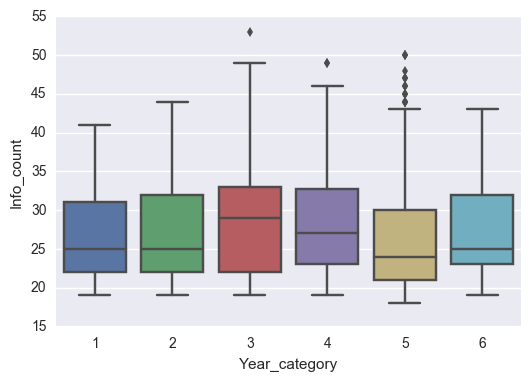

In [271]:
def year_category(year):
    return '1' if year < 1960\
            else '2' if year < 1971 \
            else '3' if year < 1981\
            else '4' if year < 1991\
            else '5' if year < 2001\
            else "6" if year < 2015\
            else '0'

data2['Year_category'] = data2['Birth_year'].apply(year_category)
sns.boxplot(x='Year_category', y='Info_count', data=data2)

In [272]:
X = data2
y = data2['Year_category']

X = X.drop(['Year_category'], axis=1) 
X = X.drop(['Birth_year'], axis=1) 

In [273]:
X_train, X_30, y_train, y_30 = train_test_split(X, y, test_size=0.3, random_state=7)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_30_scaled = scaler.transform(X_30)

## Линейная регрессия

In [274]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Оценим среднеквадратичную ошибку модели на обучающей и отложенной выборках.**

In [275]:
# на обучающей
predicted_error = linreg.predict(X_train_scaled)
mean_squared_error (y_train, predicted_error)

0.6165801540543917

In [276]:
# на тестовой
predicted_error_30 = linreg.predict(X_30_scaled)
mean_squared_error (y_30, predicted_error_30)

0.66253563320480047

**Посмотрим на коэффициенты модели и отранжируем признаки по влиянию (большие по модулю отрицательные значения коэффициентов тоже говорят о сильном влиянии). Создайте для этого новый небольшой DataFrame.**

In [277]:
linreg_coef = pd.DataFrame(linreg.coef_,index=X.columns)
linreg_coef.sort_values(0)

,0
sex,-6.600925e+10
online_mobile,-1.109266e+06
platform,-6.653715e-02
relation,-4.742801e-02
graduation_1,-4.572678e-02
Info_count,-3.363037e-02
can_post,-3.219574e-02
online_app,-2.418041e-02
can_write_private_message,-2.123441e-02
country_id,-1.767234e-02


## Lasso-регрессия

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha = 0.01$ (слабая регуляризация). Пусть опять random_state=7.**

In [278]:
alpha = 0.01
lasso_small = Lasso(alpha, random_state=7)
lasso_small.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=7,
   selection='cyclic', tol=0.0001, warm_start=False)

**Посмотрим на коэффициенты модели и отранжируйте признаки по влиянию на качество вина. Какой признак "отвалился" первым, то есть наименее важен для объяснения целевого признака в модели Lasso?**

In [279]:
lasso1_coef = pd.DataFrame(lasso_small.coef_,index=X.columns)
lasso1_coef.sort_values(0)

,0
platform,-0.052186
graduation_1,-0.042202
relation,-0.039850
can_post,-0.023437
Info_count,-0.022721
online_app,-0.009048
country_id,-0.007051
can_write_private_message,-0.006704
followers,-0.002504
user_videos,-0.000490


**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации 5-кратной кросс-валидации. Используйте LassoCV и random_state=7.**

In [280]:
import numpy as np
alphas = np.linspace(0.1, 10, 200)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)
lasso_cv.alpha_

0.10000000000000001

Лучшим получилось значение 0.1, но можно посмотреть еще и другие:

In [281]:
alphas = np.linspace(0.02, 0.05, 1)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)
lasso_cv.alpha_

0.02

Оставим 0.02

In [282]:
alpha_best = 0.02

In [283]:
lasso2 = Lasso(alpha=alpha_best, random_state=7)
lasso2.fit(X_train_scaled, y_train)
lasso2_cv_coef = pd.DataFrame(lasso2.coef_,index=X.columns)
lasso2_cv_coef.sort_values(0)

,0
platform,-0.039891
graduation_1,-0.038692
relation,-0.031797
can_post,-0.014373
Info_count,-0.014083
no_search,0.000000
duration,0.000000
user_videos,-0.000000
groups,-0.000000
gifts,-0.000000


**Оценим среднеквадратичную ошибку модели на обучающей и тестовой выборках.**

In [284]:
# на обучающей
predicted_error_lasso1 = lasso_small.predict(X_train_scaled)
print("MSE на обучающей, alpha=0.01: ", mean_squared_error (y_train, predicted_error_lasso1))

MSE на обучающей, alpha=0.01:  0.618685038832


In [285]:
# на обучающей
predicted_error_lasso2 = lasso2.predict(X_train_scaled)
print("MSE на обучающей, alpha=0.02: ", mean_squared_error (y_train, predicted_error_lasso2))

MSE на обучающей, alpha=0.02:  0.622177329872


In [286]:
# на тестовой 
predicted_error_lasso1 = lasso_small.predict(X_30_scaled)
print("MSE на тестовой, alpha=0.01: ", mean_squared_error (y_30, predicted_error_lasso1))

MSE на тестовой, alpha=0.01:  0.664559205796


In [287]:
# на тестовой 
predicted_error_lasso2 = lasso2.predict(X_30_scaled)
print("MSE на тестовой, alpha=0.02: ", mean_squared_error (y_30, predicted_error_lasso2))

MSE на тестовой, alpha=0.02:  0.668581842693


С lasso возрастная классификация пока не очень получилась, попробуем случайный лес

## Случайный лес

**Обучим случайный лес с параметрами "из коробки", фиксируя только random_state=7.**

In [288]:
forest = RandomForestRegressor(random_state = 7)
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

**Оценим среднеквадратичную ошибку модели на обучающей выборке, на кросс-валидации (cross_val_score с scoring='mean_squared_error' и остальными параметрами по умолчанию) и на оставленной выборке.**

In [289]:
# на обучающей
n_folds = 5
scores = cross_val_score(RandomForestRegressor(random_state = 7), X_train_scaled, y_train, 
                         scoring='mean_squared_error', cv=5)
print(scores)
scores.mean()

[-0.61442702 -0.76353412 -0.74438894 -0.66724185 -0.69275008]


-0.69646840272119859

In [290]:
# на тестовой
n_folds = 5
scores_test = cross_val_score(RandomForestRegressor(random_state = 7), X_30_scaled, y_30, 
                         scoring='mean_squared_error', cv=5)
print(scores_test)
scores_test.mean()

[-0.82134944 -0.84598508 -0.76526036 -0.6933724  -0.8281589 ]


-0.79082523624061074

Ну что же, из коробки получилось еще хуже. Настроим параметры

**Настроим параметры min_samples_leaf и max_depth с помощью GridSearchCV и опять проверим качество модели на кросс-валидации и на оставленной выборке.**

In [291]:
forest_params = {'max_depth': list(range(15, 20)), 
                 'min_samples_leaf': list(range(2, 8))}

locally_best_forest = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=7), 
                                 forest_params, 
                                 scoring='mean_squared_error',  
                                 n_jobs=-1, cv=5)
locally_best_forest.fit(X_train_scaled, y_train)
clf_best_param = locally_best_forest.best_params_
clf_best_param

{'max_depth': 15, 'min_samples_leaf': 7}

In [292]:
# на обучающей
n_folds = 5
scores = cross_val_score(RandomForestRegressor(min_samples_leaf = 7, max_depth = 15,random_state = 7),
                         X_train_scaled, y_train, 
                         scoring='mean_squared_error', cv=5)
print(scores) 
scores.mean()

[-0.49327046 -0.61172409 -0.6046017  -0.59338384 -0.64279474]


-0.58915496568488768

In [293]:
# на тестовой
n_folds = 5
scores_30 = cross_val_score(RandomForestRegressor(min_samples_leaf = 7, max_depth = 15,random_state = 7),
                         X_30_scaled, y_30, 
                         scoring='mean_squared_error', cv=5)
print(scores_30) 
scores_30.mean()

[-0.72161956 -0.69809848 -0.56406306 -0.62552908 -0.62924806]


-0.6477116489382001

In [294]:
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
           verbose=0, warm_start=False)

**Оценим важность признаков с помощью случайного леса.**

In [295]:
best_forest = RandomForestRegressor(min_samples_leaf = 3, max_depth = 17, random_state = 7)
best_forest.fit(X_train_scaled, y_train)
best_forest_predictions = best_forest.predict(X_train_scaled)
rf_importance = pd.DataFrame(best_forest.feature_importances_, index=X.columns,
                        columns=['Importance']).sort(['Importance'], ascending=True)
rf_importance

,Importance
no_search,0.000000
online_mobile,0.000000
notes,0.000584
user_videos,0.001917
can_write_private_message,0.002247
has_mobile,0.005408
duration,0.007851
albums,0.009437
can_post,0.009891
can_see_all_posts,0.010036


In [296]:
best_forest_30 = RandomForestRegressor(min_samples_leaf = 3, max_depth = 17, random_state = 7)
best_forest_30.fit(X_30_scaled, y_30)
best_forest_predictions_30 = best_forest_30.predict(X_30_scaled)
rf_importance_30 = pd.DataFrame(best_forest_30.feature_importances_, index=X.columns,
                        columns=['Importance on test set'])
rf_importance_30

,Importance on test set
can_see_all_posts,0.009329
has_mobile,0.002875
country_id,0.139808
online,0.014959
sex,0.018250
can_post,0.009402
can_write_private_message,0.000723
platform,0.041132
relation,0.150092
city,0.021860


In [297]:
rf_importance_all = pd.DataFrame(best_forest.feature_importances_, index=X.columns,
                        columns=['Importance'])

rf_importance_all['Importance on test set'] = pd.DataFrame(best_forest_30.feature_importances_, index=X.columns,
                        columns=['Importance on test set'])
rf_importance_all

,Importance,Importance on test set
can_see_all_posts,0.010036,0.009329
has_mobile,0.005408,0.002875
country_id,0.071045,0.139808
online,0.013960,0.014959
sex,0.023428,0.018250
can_post,0.009891,0.009402
can_write_private_message,0.002247,0.000723
platform,0.048953,0.041132
relation,0.198120,0.150092
city,0.041978,0.021860
